In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import os
import sys
import glob
import torch
import time
from cace.tasks import LightningTrainingTask
from deeporb.data import OrbDataset, OrbData
from deeporb.ceonet import CEONet
from cace.models import NeuralNetworkPotential
from deeporb.atomwise import AttentionAtomwise
from cace.tasks import GetLoss
from deeporb.metrics import Metrics
import numpy as np
import matplotlib.pyplot as plt
import hashlib
from pathlib import Path
import h5py

In [41]:
def load_h5_as_dict(file_path:Path):
    data_dict = {}
    with h5py.File(file_path, 'r') as h5_file:
        for group_name in h5_file.keys():
            group = h5_file[group_name]
            group_data = {}
            for key in group.keys():
                group_data[key] = group[key][()]
            data_dict[group_name] = group_data
    return data_dict

def tensor_hash(tensor):
    return hashlib.md5(tensor.cpu().numpy().tobytes()).hexdigest()

def verify_with_hash(h5_path, pt_path):
    data_h5 = load_h5_as_dict(Path(h5_path))
    for group, datasets in data_h5.items():
        for key, value in datasets.items():
            if not isinstance(value, torch.Tensor):
                data_h5[group][key] = torch.tensor(value)
    
    data_pt = torch.load(Path(pt_path))
    
    for group in data_h5:
        if group not in data_pt:
            print(f"Group '{group}' not found in the pt file.")
            continue

        for key in data_h5[group]:
            if key not in data_pt[group]:
                print(f"Key '{key}' in group '{group}' not found in the pt file.")
                continue

            hash_h5 = tensor_hash(data_h5[group][key])
            hash_pt = tensor_hash(data_pt[group][key])
            
            if hash_h5 != hash_pt:
                print(f"Hash mismatch for group '{group}', key '{key}': {hash_h5} vs {hash_pt}")
            else:
                #print(f"Group '{group}', key '{key}' verified")
                continue
    print("Hash-based verification complete.")

In [42]:
verify_with_hash("../data/sto3g/sto3g_occ_10000.h5", "../data/sto3g/sto3g_occ_10000.pt" )

Hash-based verification complete.


In [43]:
mean_std_dct = {
    "qh9_occ":[-0.5144,0.2229],
    "qh9_virt":[1.4346,0.9854],
    "qh9_v12":[0.5353,0.3168],
    "sto3g_occ":[-0.6605,0.2801],
    "sto3g_virt":[0.6892,0.1825],
    "tm_occ":[-0.6154,0.2862],
    "tm_virt":[0.6896,0.2229],
    "qh9_all":[1.1572,1.1341],
    "sto3g_all":[-0.0188,0.7169],
    "tm_all":[-0.0234,0.7003],
    "kl_constructed":[0,1],
    "qh9_class_occ":[0,1],
    "qh9_class_forb":[0,1],
    "qh9_balanced":[0,1],
    "sto3g_balanced":[0,1],
    "sto3g_class_occ":[-0.0188,0.7169],
    "b3lyp_occ":[-0.4527,0.2246],
    "b3lyp_virt":[0.4318,0.1652],
    "nan":[0,1],
}

In [4]:
#Write here
LOGS_NAME = "sto3g_occ_1000000"
DATA_NAME = "sto3g_occ"
SUBSET_SIZE = "1000000"

#Model params
CUTOFF = 7.6
LINMAX = 1
LOMAX = 2
NC = 16
LAYERS = 2
N_RBF = 16
N_RSAMPLES = 16
STACKING = True
IRREP_MIXING = False
CHARGE_EMBEDDING = False

#Data params
BATCH_SIZE = 128
#NUM_TRAIN = 5120
#NUM_VAL = 10000
IN_MEMORY = True
AVGE0 = -0.6605
SIGMA = 0.2801


DEV_RUN = False
LR = 0.001
MAX_STEPS = 600000

on_cluster = False

In [5]:
root = f"../data/{DATA_NAME.split('_')[0]}/{DATA_NAME.split('.')[0]}_{SUBSET_SIZE}.pt"

print(root)

torch.multiprocessing.set_sharing_strategy('file_system')
in_memory = True

print("Making dataset...")
time_start = time.perf_counter()
data = OrbData(data_path=root,batch_size=BATCH_SIZE,cutoff=CUTOFF,avge0=AVGE0,sigma=SIGMA)
#data = OrbData(root=root,batch_size=BATCH_SIZE,num_val=NUM_VAL,num_train=NUM_TRAIN,cutoff=CUTOFF,in_memory=in_memory,avge0=AVGE0,sigma=SIGMA)
time_stop = time.perf_counter()
print("Time elapsed:",time_stop-time_start)

representation = CEONet(NC,cutoff=CUTOFF,n_rbf=N_RBF,n_rsamples=N_RSAMPLES,stacking=STACKING,irrep_mixing=IRREP_MIXING,
                        linmax=LINMAX,lomax=LOMAX,layers=LAYERS,charge_embedding=CHARGE_EMBEDDING)

atomwise = AttentionAtomwise(
                    output_key='pred_energy',
                    n_hidden=[32,16],
                    attention_hidden_nc=128,
                    avge0=AVGE0,sigma=SIGMA,
                    bias=True
                   )

model = NeuralNetworkPotential(
    input_modules=None,
    representation=representation,
    output_modules=[atomwise]
)

e_loss = GetLoss(
            target_name="energy_ssh",
            predict_name='pred_energy',
            loss_fn=torch.nn.MSELoss(),
            loss_weight=1,
            )
losses = [e_loss]

e_metric = Metrics(
            target_name="energy",
            predict_name='pred_energy',
            name='e',
            metric_keys=["mae"],
            avge0=AVGE0,sigma=SIGMA,
            per_atom=False,
        )
metrics = [e_metric]

../data/sto3g/sto3g_occ_1000000.pt
Making dataset...
Time elapsed: 3.095902502536774e-05


In [6]:
#Check for checkpoint and restart if found:
chkpt = None
dev_run = DEV_RUN
if os.path.isdir(f"../data/lightning_logs/{LOGS_NAME}"):
    latest_version = None
    num = 0
    while os.path.isdir(f"../data/lightning_logs/{LOGS_NAME}/version_{num}"):
        latest_version = f"../data/lightning_logs/{LOGS_NAME}/version_{num}"
        num += 1
    print(latest_version)
    if latest_version:
        chkpt_list = glob.glob(f"{latest_version}/checkpoints/*.ckpt")
        print(len(chkpt_list))
        if len(chkpt_list)>0:
            chkpt = chkpt_list[0]
if chkpt:
    print("Checkpoint found!",chkpt)
    print("Restarting...")
    dev_run = False

progress_bar = True
#if on_cluster:
#    torch.set_float32_matmul_precision('medium')
#    progress_bar = False

#torch.set_float32_matmul_precision('medium')

#task = LightningTrainingTask(model,losses=losses,metrics=metrics,metric_typ="mae",
#                             logs_directory="lightning_logs",name=LOGS_NAME,
#                             scheduler_args={'mode': 'min', 'factor': 0.8, 'patience': 10},
#                             optimizer_args={'lr': LR},
#                            )

task = LightningTrainingTask(model,losses=losses,metrics=metrics,
                             logs_directory="lightning_logs",name=LOGS_NAME,
                             scheduler_args={'mode': 'min', 'factor': 0.8, 'patience': 10},
                             optimizer_args={'lr': LR},
                            )

../data/lightning_logs/sto3g_occ_1000000/version_1
1
Checkpoint found! ../data/lightning_logs/sto3g_occ_1000000/version_1/checkpoints/epoch=383-step=600000.ckpt
Restarting...


In [7]:
data

In [9]:
task.model = task.model.eval()

In [10]:
data.setup()

calling prepare data
reading pt file
1000000
calling setup
1000000
800000


In [23]:
pred_energies = []
true_energies = []

In [24]:
with torch.no_grad():
    for batch in data.test_dataloader():
        out = task.model(batch)
        pred_energy = out["pred_energy"]
        pred_energy = pred_energy.cpu().detach().numpy()
        pred_energies.append(pred_energy)
        true_energy = batch["energy"].cpu().detach().numpy()
        true_energies.append(true_energy)
        # break

In [25]:
true_energies[0]

array([-0.39725903, -0.5367772 , -0.6426669 , -0.5081031 , -0.8654111 ,
       -0.5422686 , -0.63419044, -1.1934551 , -0.56221145, -0.7747564 ,
       -0.35956272, -0.56216204, -0.68662024, -1.0308315 , -0.90770847,
       -0.41381052, -0.5796786 , -0.30017337, -0.4196319 , -0.74525064,
       -0.3786285 , -0.6797848 , -0.5562829 , -0.43031105, -0.43275735,
       -0.5935139 , -1.4557226 , -0.29575682, -0.72448736, -0.31776485,
       -0.726965  , -0.51860034, -0.4183413 , -0.3149897 , -0.5743694 ,
       -0.36299416, -0.5219199 , -0.4850782 , -1.3065517 , -0.60299826,
       -0.37320757, -0.57895154, -0.5261393 , -0.55129737, -1.0021585 ,
       -1.3503816 , -0.73059654, -0.3696467 , -1.370544  , -0.908999  ,
       -0.33329985, -0.45867008, -0.53228295, -0.5294453 , -0.5134679 ,
       -1.3138013 , -0.73989654, -0.84994465, -1.4127976 , -0.86745423,
       -0.37788656, -0.6421937 , -0.50199145, -1.4216927 , -1.0394399 ,
       -0.5144468 , -0.3114125 , -0.51008284, -1.1880149 , -0.48

In [26]:
pred_energies[0] 

array([-0.08295473, -0.10599605, -0.10063773, -0.1025221 , -0.07665101,
       -0.0910446 , -0.08143388, -0.10116056, -0.11609384, -0.10163264,
       -0.08948466, -0.08362755, -0.08713658, -0.08527625, -0.0827287 ,
       -0.08276056, -0.08181411, -0.09690216, -0.09125093, -0.08448278,
       -0.10231747, -0.09782499, -0.07542475, -0.11182649, -0.08558099,
       -0.08236105, -0.08377305, -0.09273501, -0.08834806, -0.08813842,
       -0.09865288, -0.09230526, -0.08137369, -0.09101903, -0.09146767,
       -0.09878822, -0.08572769, -0.10042706, -0.0838443 , -0.0846217 ,
       -0.09609735, -0.10091926, -0.09024816, -0.10567141, -0.08026864,
       -0.08063302, -0.08133046, -0.09407789, -0.085957  , -0.1075815 ,
       -0.09119093, -0.09019299, -0.08186673, -0.07228427, -0.10625073,
       -0.09185582, -0.09424545, -0.10566951, -0.08197208, -0.07958107,
       -0.11840694, -0.08714095, -0.10431495, -0.07684635, -0.11095307,
       -0.11639562, -0.11297242, -0.10062468, -0.08377688, -0.08

In [30]:
pred_energies = np.hstack(pred_energies)
true_energies = np.hstack(true_energies)

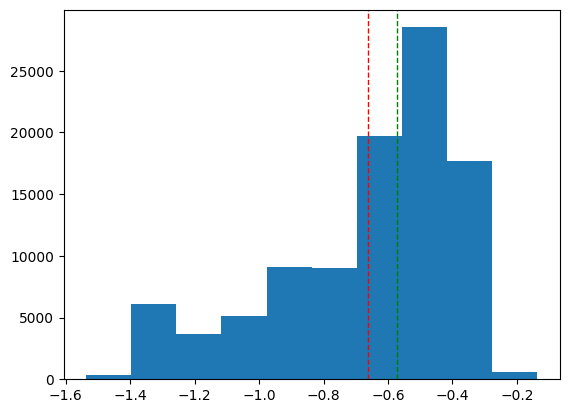

In [31]:
mean_val = np.mean(true_energies)
median_val = np.median(true_energies)

plt.hist(true_energies)
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')

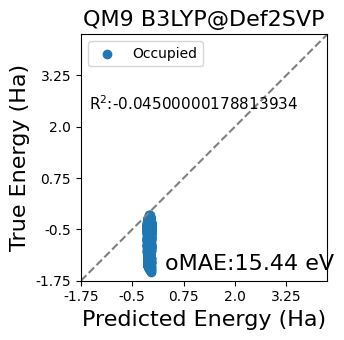

In [33]:
import scipy
import matplotlib.pyplot as plt
plt.figure(figsize=(3.5,3.5))
plt.scatter(pred_energies,true_energies,label="Occupied")
#plt.scatter(virt_pred,virt_true,label="Virtual")
hartree_to_ev = 27.2114
tot_pred = np.hstack([pred_energies]) #virt_pred
tot_true = np.hstack([true_energies]) #virt_true
occ_mae = np.abs(pred_energies - true_energies).mean()
#virt_mae = np.abs(virt_pred - virt_true).mean()
mae = np.abs(pred_energies - true_energies).mean()
mae = np.round(mae*hartree_to_ev,2)
occ_mae = np.round(occ_mae*hartree_to_ev,2)
#virt_mae = np.round(virt_mae*hartree_to_ev,2)
r2 = np.round(scipy.stats.pearsonr(tot_pred,tot_true)[0],3)
xmin, xmax = -1.75, 4.25
s = 1.25
x = y = np.arange(xmin,xmax+1)
plt.plot(x,y,linestyle="--",color="grey")
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
tcks = np.round(np.arange(xmin,xmax,s),2)
plt.xticks(tcks,tcks)
plt.yticks(tcks,tcks)
plt.gca().set_aspect('equal')
plt.legend()
djvfont = {'fontname':'DejaVu Sans'}
fs=16
plt.xlabel("Predicted Energy (Ha)",fontsize=fs,**djvfont)
plt.ylabel("True Energy (Ha)",fontsize=fs,**djvfont)
plt.title("QM9 B3LYP@Def2SVP",fontsize=fs,**djvfont)
plt.text(-1.55,2.4,f"R$^2$:{r2}",fontsize=11,**djvfont)
#plt.text(0.3,-0.75,f"vMAE:{virt_mae} eV",fontsize=fs,**djvfont)
plt.text(0.3,-1.5,f"oMAE:{occ_mae} eV",fontsize=fs,**djvfont)
plt.tight_layout()
#plt.savefig("figures/sto3g_parity.png",dpi=500)